In [106]:
import pandas as pd

# Path to your txt file
file_path = "data/after_intervention/measurements_imaging_state/experiments/battery/Powerstat.txt"

# Read lines, skip headers, and collect data lines
with open(file_path, "r") as f:
    lines = f.readlines()

# Keep only the lines that do NOT start with "Time"
data_lines = [line.strip() for line in lines if not line.strip().startswith("Time")]
data_lines = [line.strip() for line in lines if not line.strip().startswith("--------")]


# Create a temporary header (column names)
columns = ["Time", "User", "Nice", "Sys", "Idle", "IO", "Run", "Ctxt/s", "IRQ/s", "Watts", "soc-th", "cpu-th"]

# Convert cleaned data into DataFrame
df = pd.DataFrame([line.split() for line in data_lines], columns=columns)

# Display the result
df.drop('Watts', axis=1, inplace=True)
df.head()

,Time,User,Nice,Sys,Idle,IO,Run,Ctxt/s,IRQ/s,soc-th,cpu-th
0,Time,User,Nice,Sys,Idle,IO,Run,Ctxt/s,IRQ/s,soc-th,cpu-th\
1,11:04:04,10.8,0.0,0.8,88.0,0.5,1,1803,1464,48.00,48.00\
2,11:04:05,22.6,0.0,3.4,73.7,0.3,2,7405,4852,49.00,48.00\
3,11:04:06,21.7,0.0,2.6,75.7,0.0,1,6358,3656,48.00,48.00\
4,11:04:07,20.9,0.0,0.5,78.5,0.0,1,5423,3362,49.00,48.00\


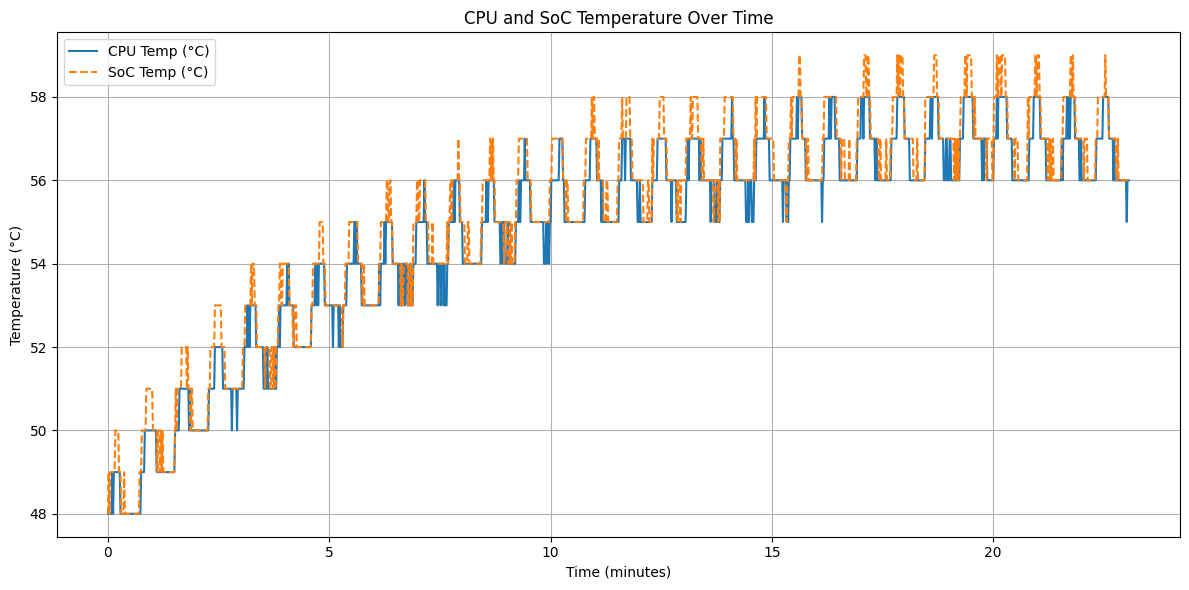

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Remove header/summary rows
skip_keywords = ['Time', 'Average', 'GeoMean', 'StdDev', 'Minimum', 'Maximum']
df_clean = df[~df['Time'].isin(skip_keywords)].copy()

# Step 2: Remove backslashes and strip whitespace
df_clean = df_clean.map(lambda x: str(x).replace('\\', '').strip())

# Step 3: Convert temperature columns to numeric
df_clean['cpu-th'] = pd.to_numeric(df_clean['cpu-th'], errors='coerce')
df_clean['soc-th'] = pd.to_numeric(df_clean['soc-th'], errors='coerce')

# Step 4: Drop rows with invalid values
df_clean = df_clean.dropna(subset=['cpu-th', 'soc-th'])

# Step 5: Add a synthetic time axis in seconds
df_clean['Seconds'] = range(len(df_clean))  # each row = 1 second
df_clean['Minutes'] = df_clean['Seconds'] / 60

# Step 6: Plot
plt.figure(figsize=(12, 6))
plt.plot(df_clean['Minutes'], df_clean['cpu-th'], label='CPU Temp (°C)')
plt.plot(df_clean['Minutes'], df_clean['soc-th'], label='SoC Temp (°C)', linestyle='--')

plt.title('CPU and SoC Temperature Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


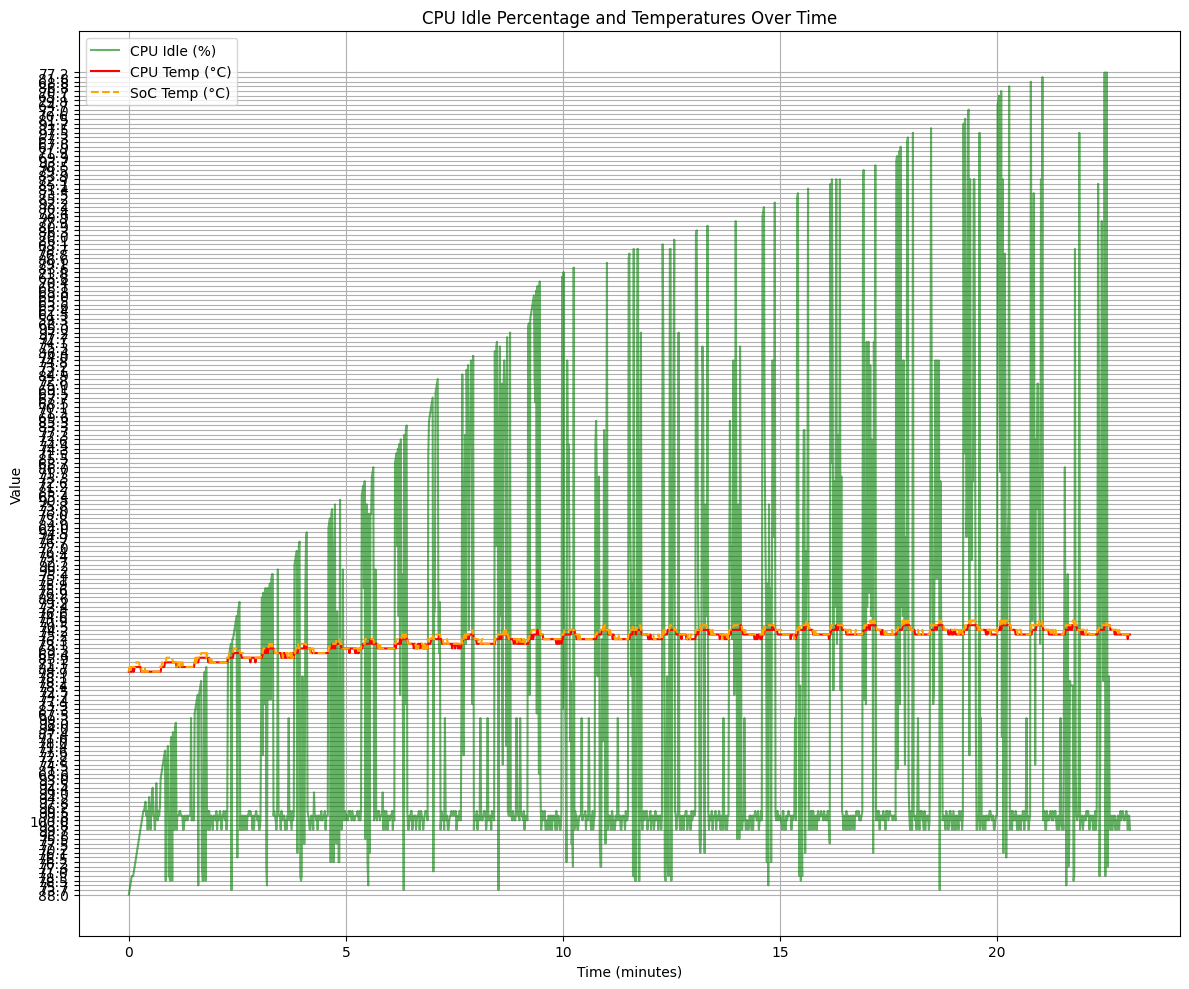

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Plot all three metrics
plt.plot(df_clean['Minutes'], df_clean['Idle'], label='CPU Idle (%)', color='green', alpha=0.6)
plt.plot(df_clean['Minutes'], df_clean['cpu-th'], label='CPU Temp (°C)', color='red')
plt.plot(df_clean['Minutes'], df_clean['soc-th'], label='SoC Temp (°C)', color='orange', linestyle='--')

plt.title('CPU Idle Percentage and Temperatures Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


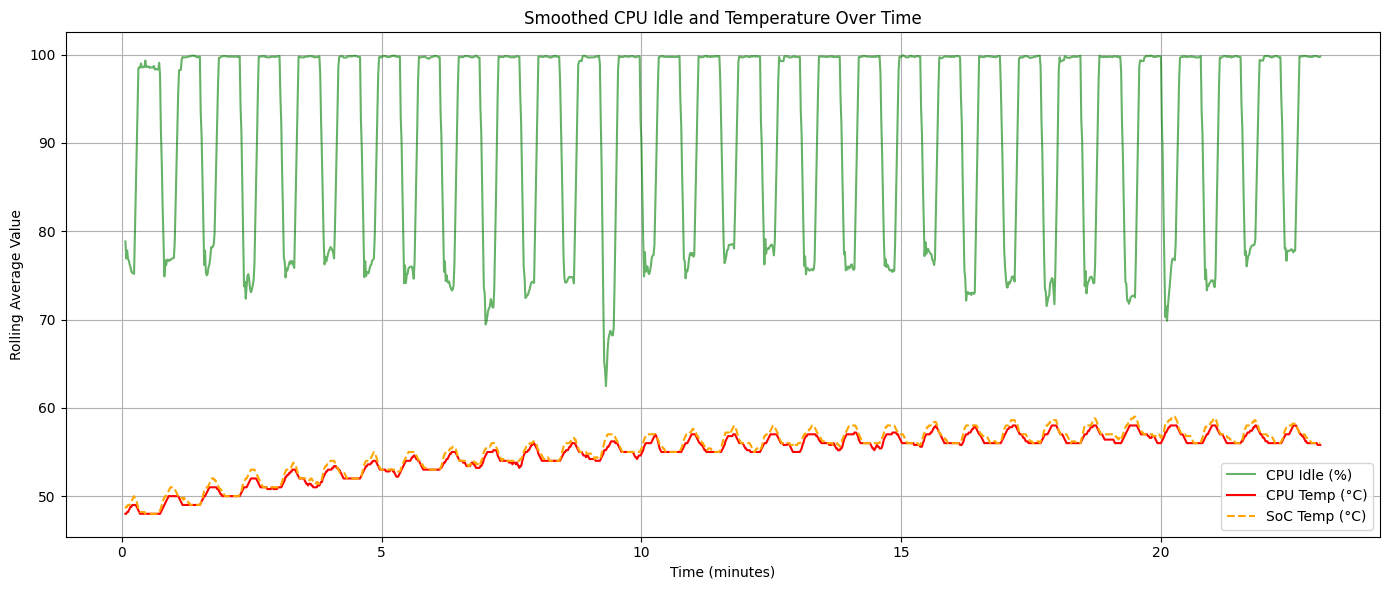

In [109]:
import matplotlib.pyplot as plt

# Apply rolling average (window=30 seconds)
df_rolling = df_clean[['Minutes', 'Idle', 'cpu-th', 'soc-th']].copy()
df_rolling['Idle'] = df_rolling['Idle'].rolling(window=5).mean()
df_rolling['cpu-th'] = df_rolling['cpu-th'].rolling(window=5).mean()
df_rolling['soc-th'] = df_rolling['soc-th'].rolling(window=5).mean()

# Plot smoothed lines
plt.figure(figsize=(14, 6))
plt.plot(df_rolling['Minutes'], df_rolling['Idle'], label='CPU Idle (%)', color='green', alpha=0.6)
plt.plot(df_rolling['Minutes'], df_rolling['cpu-th'], label='CPU Temp (°C)', color='red')
plt.plot(df_rolling['Minutes'], df_rolling['soc-th'], label='SoC Temp (°C)', color='orange', linestyle='--')

plt.title('Smoothed CPU Idle and Temperature Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Rolling Average Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('data/after_intervention/measurements_imaging_state/experiments/battery/results_plots/cpu_temp_plot.png', dpi=300, bbox_inches='tight')
plt.show()


## Comparing 2 scenarios: after and before intervention: Powerstat data

In [130]:
def load_and_process(path):
    with open(path, 'r') as f:
        lines = f.readlines()

    # Filter out headers and summary rows
    skip_keywords = ['Time', 'Average', 'GeoMean', 'StdDev', 'Minimum', 'Maximum']
    data_lines = [line.strip().replace('\\', '') for line in lines if not any(kw in line for kw in skip_keywords)]

    # Split lines by whitespace and create DataFrame
    split_data = [line.split() for line in data_lines]

    # Assign correct column names
    columns = ["Time", "User", "Nice", "Sys", "Idle", "IO", "Run", "Ctxt/s", "IRQ/s", "Watts", "soc-th", "cpu-th"]
    df = pd.DataFrame(split_data, columns=columns)

    # Convert numeric columns
    for col in ['Idle', 'soc-th', 'cpu-th']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=['cpu-th', 'soc-th', 'Idle'])

    df['Seconds'] = range(len(df))
    df['Minutes'] = df['Seconds'] / 60

    # Rolling average
    df['cpu-th'] = df['cpu-th'].rolling(window=10).mean()
    df['soc-th'] = df['soc-th'].rolling(window=10).mean()
    df['Idle'] = df['Idle'].rolling(window=10).mean()

    return df


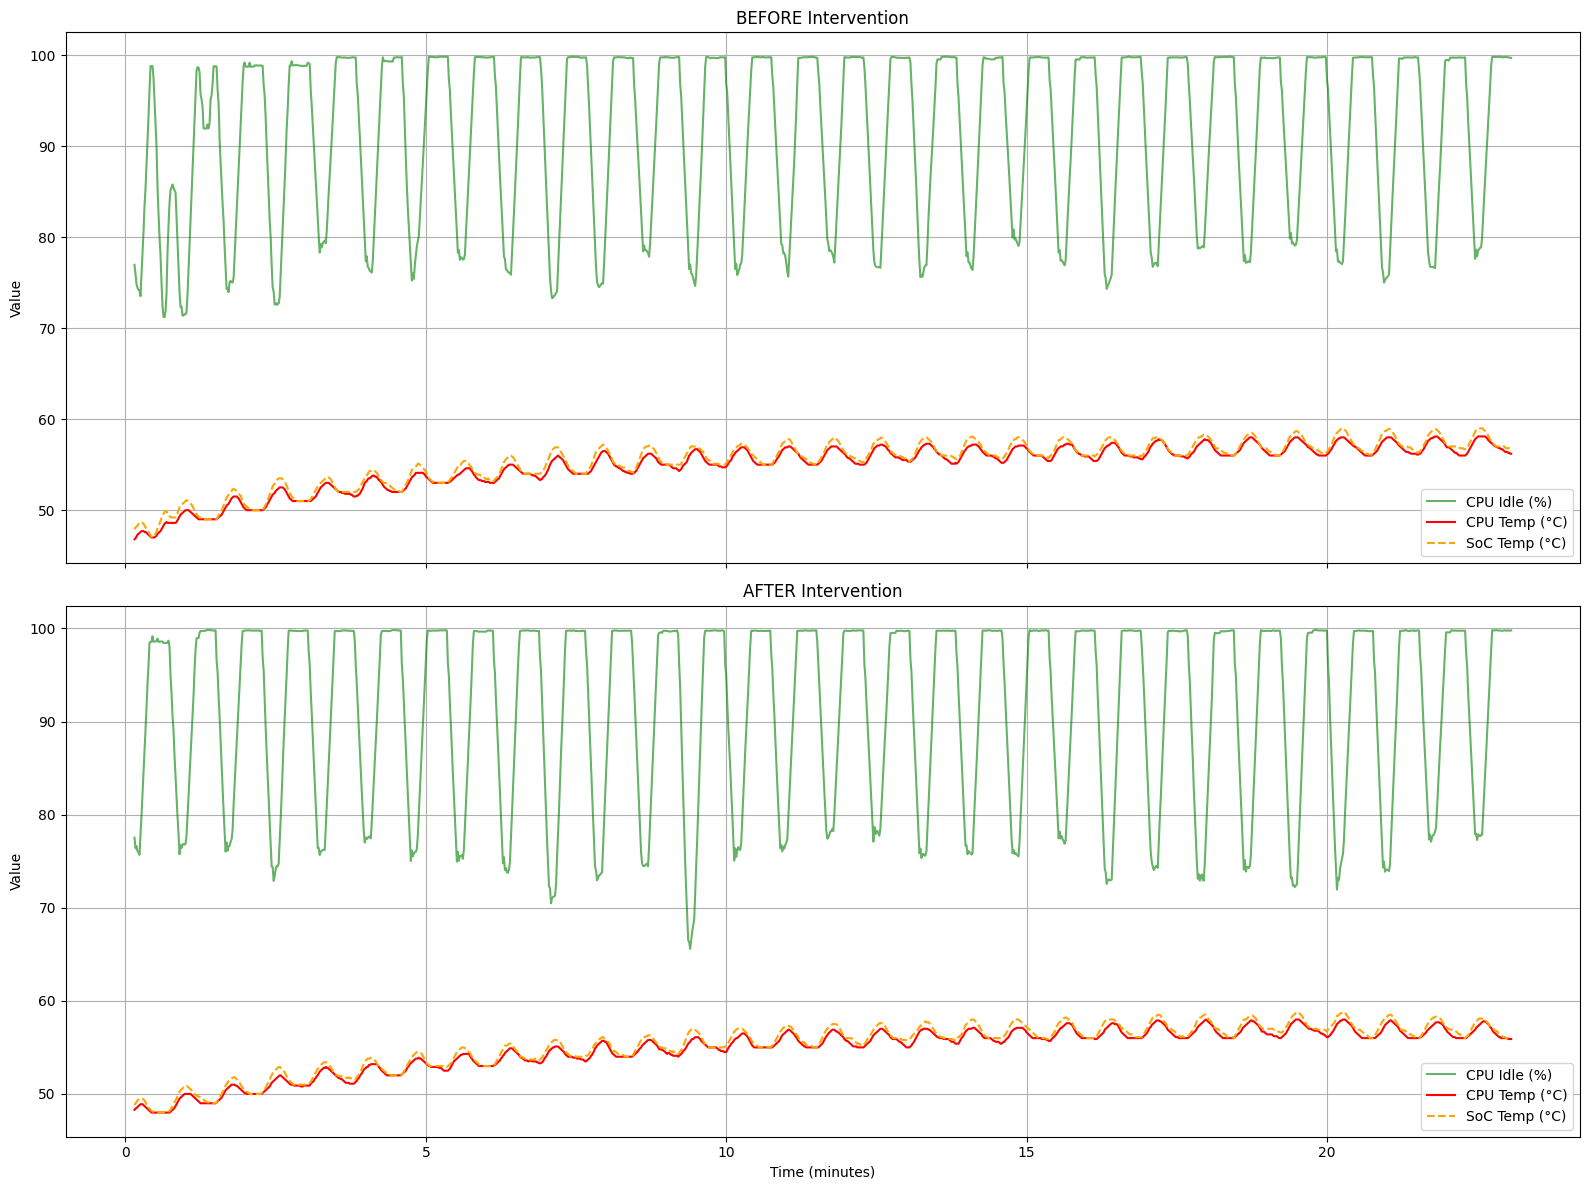

In [138]:
# Paths to files
before_path = "data/before_intervention/measurements_imaging_state/experiments/battery/Powerstat.txt"
after_path = "data/after_intervention/measurements_imaging_state/experiments/battery/Powerstat.txt"

# Load both datasets
df_before = load_and_process(before_path)
df_after = load_and_process(after_path)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Before intervention
ax1.plot(df_before['Minutes'], df_before['Idle'], label='CPU Idle (%)', color='green', alpha=0.6)
ax1.plot(df_before['Minutes'], df_before['cpu-th'], label='CPU Temp (°C)', color='red')
ax1.plot(df_before['Minutes'], df_before['soc-th'], label='SoC Temp (°C)', color='orange', linestyle='--')
ax1.set_title("BEFORE Intervention")
ax1.set_ylabel("Value")
ax1.legend()
ax1.grid(True)

# After intervention
ax2.plot(df_after['Minutes'], df_after['Idle'], label='CPU Idle (%)', color='green', alpha=0.6)
ax2.plot(df_after['Minutes'], df_after['cpu-th'], label='CPU Temp (°C)', color='red')
ax2.plot(df_after['Minutes'], df_after['soc-th'], label='SoC Temp (°C)', color='orange', linestyle='--')
ax2.set_title("AFTER Intervention")
ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("Value")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# plt.savefig("/data/comparison_before_after.png", dpi=300, bbox_inches='tight')
plt.show()


In [145]:
print("BEFORE")
print(df_before[['cpu-th', 'soc-th']].describe())
print("AFTER")
print(df_after[['cpu-th', 'soc-th']].describe())

print(df_before[['cpu-th', 'soc-th']].min())
print(df_after[['cpu-th', 'soc-th']].min())



BEFORE
            cpu-th       soc-th
count  1376.000000  1376.000000
mean     54.866642    55.309520
std       2.489042     2.515012
min      46.800000    47.000000
25%      53.800000    54.000000
50%      55.700000    56.000000
75%      56.600000    57.000000
max      58.100000    59.000000
AFTER
            cpu-th       soc-th
count  1376.000000  1376.000000
mean     54.754506    55.167951
std       2.443311     2.513949
min      48.000000    48.000000
25%      53.500000    53.800000
50%      55.600000    56.000000
75%      56.500000    57.000000
max      58.000000    58.800000
cpu-th    46.8
soc-th    47.0
dtype: float64
cpu-th    48.0
soc-th    48.0
dtype: float64


In [140]:
before_max = df_before[['cpu-th', 'soc-th']].max()
after_max = df_after[['cpu-th', 'soc-th']].max()
print("ΔCPU Temp:", after_max['cpu-th'] - before_max['cpu-th'])


ΔCPU Temp: -0.10000000000000142


In [136]:
df_before[['Idle', 'cpu-th', 'soc-th']].corr()
df_after[['Idle', 'cpu-th', 'soc-th']].corr()


,Idle,cpu-th,soc-th
Idle,1.000000,0.078602,0.064078
cpu-th,0.078602,1.000000,0.996444
soc-th,0.064078,0.996444,1.000000
